In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science: 

## Homework 3: Polynomial and LASSO Regression

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2.4pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<div style = "background: lightgreen; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with slighlty longer output. Avoid excessively long output.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [3]:
from collections import Counter
import math
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)

In [4]:
# For calculating total notebook runtime
notebook_start = time.time()

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data visualization [4 pts]**](#part1)

- [**Your Homework 3 roadmap**](#roadmap)


- [**Question 2: Guesstimate the polynomial relationship [22 pts]**](#part2)

- [**Question 3: Use a validation set to find the most promising polynomial relationship [12 pts]**](#part3)

- [**Question 4: Finding the best model by k-fold cross validation [14 pts]**](#part4)

- [**Question 5: Finding the most consistent model using k-fold cross validation with bootstraps [16 pts]**](#part5)

- [**Question 6: Improving model consistency with LASSO regularization [26 pts]**](#part6)

- [**Question 7: Analyze your best test MSEs for each section of the homework [6 pts]**](#part7)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting percentage change in bacteria populations given their spreading factor

In this homework, we will explore polynomial regression for modeling a quantitative variable. Specifically, we will model the percent change in a bacteria population after 4 hours as a function of the bacteria's "spreading factor".

**The data set for this problem has already been split for you.** You will find the train and test data sets in the files `data/bacteria_train.csv` and `data/bacteria_test.csv`, respectively.

### Problem Description

We will predict the percentage change in population, given the spreading factor. Thus, we will consider the `Spreading_factor` to be our predictor variable and `Perc_population` to be our response variable. Using mean squared error ($MSE$) as an evaluative criteria, we will explore several different approaches for finding the best fit and most robust polynomial regression for modeling this relationship.

<a id="part1"></a>

## <div class='exercise'>Question 1: Data visualization [4 pts]</div> 
    
[Return to contents](#contents)
    

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1</b></div>

Generate a *well-labeled* scatter plot of the data points in the `bacteria_train.csv` file with the spreading factor on the $x$-axis and the percentage change on the $y$-axis.

In [5]:
bacteria_train = pd.read_csv('data/bacteria_train.csv')
bacteria_test = pd.read_csv('data/bacteria_test.csv')
bacteria_train.head()

,Perc_population,Spreading_factor
0,1.535,0.190708
1,5.555,0.326928
2,-0.277,-0.459699
3,1.724,-0.193013
4,-0.550,-0.835745


In [6]:
X = ["Spreading_factor"]
X_train = bacteria_train[X]
X_test = bacteria_test[X]
y_train= bacteria_train["Perc_population"]
y_test = bacteria_test["Perc_population"]

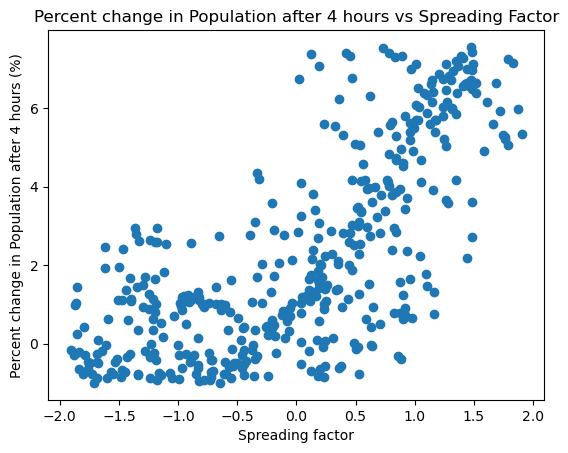

In [7]:
plt.scatter(X_train, y_train)
plt.xlabel('Spreading factor')
plt.ylabel('Percent change in Population after 4 hours (%)') 
plt.title('Percent change in Population after 4 hours vs Spreading Factor')
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2</b></div>

Based on the graph above, is there any discernable relationship between the spreading factor and percentage change in population? If so, how would you describe this relationship?

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Yes, there is a relationship. We see that for higher spreading factors, there is more population change. That said, it doesn't look linear. When spreading factor increases from -2 to -1, the population change barely increeases wheras when the spreading factor incresases from 1-2, the population change incresases dramatically. This may mean the relationship is quadratic or polynomail!

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<a id="roadmap"></a>

<hr style='height:2px'> 

## Your Homework 3 roadmap

[Return to contents](#contents)

**We will be following this roadmap throught the notebook**

![](./data/roadmap.png)


<a id="part2"></a>

## <div class='exercise'>Question 2: Guesstimate the polynomial relationship [22 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1</b></div>

Based on your inspection in question 1, guesstimate the degree of the polynomial you believe would best fit the training while still generalizing well. Store this degree in the variable `guessed_deg`. 

Next, use `PolynomialFeatures()` to generate a design matrices of the guesstimated degree for the train and test data. Store these in `x_poly_train` and `x_poly_test`. 

**Notes:**
- **You don't need to scale your data in this assignment** (you can inspect the data to see why this might not be necessary)
- **You should *not* include a bias in the design matrix you intend to pass to the linear regression's `fit` method.**

In [8]:
guessed_deg = 2

In [9]:
def convert_to_poly(train, test, deg):
    poly = PolynomialFeatures(degree=deg, include_bias=False) 
    poly.fit(train)
    x_poly_train = poly.transform(train)
    x_labels = poly.get_feature_names_out()
    x_poly_test = poly.transform(test)
    return x_poly_train, x_poly_test, x_labels, poly


In [10]:
x_poly_train, x_poly_test, x_labels, poly = convert_to_poly(X_train, X_test, guessed_deg)

In [11]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2</b></div>

Fit a polynomial regression using scikit-learn's `LinearRegression()` on the training design matrix. 

To track and compare the performance of each of the models in this notebook, use a list of dictionaries called `results`.

Each dictionary in this list will have the keys: 'model' (a string representing the question number where the model was fit), 'train_mse', and 'test_mse'.

So, for this question, you will append a dictionary to `results` of the form:
```python
{'model': '2.2', 'train_mse': 2.6749 'test_mse': 2.734}
```
Note that your MSE scores will not be the same as those in the example dictionary.

**Hint:** Because you will be calculating MSEs for models through this notebook, you may want to abstract this process into a function for re-use.

In [12]:
results = []

In [13]:
def add_to_results(model, x_train, x_test, y_train, y_test, number):
    train_mse = mean_squared_error(y_train, model.predict(x_train))
    test_mse = mean_squared_error(y_test, model.predict(x_test))
    results.append({
        'model': number,
        'train_mse': train_mse,
        'test_mse': test_mse
    })

In [14]:
# Fit a linear regression model
model = LinearRegression().fit(x_poly_train, y_train)
add_to_results(model, x_poly_train, x_poly_test, y_train, y_test, "2.2")

In [15]:
# Display your results thus far.
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863


In [16]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3</b></div>

- Create a plot showing both the train and test data, as well as your model's prediction curve.
- Display `results` as a DataFrame.
- Explain the rationale for your choice of degree (i.e. your "guesstimation") and comment on the fit of your model.
  

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

I chose degree 2 because I wanted to capture the fact that as the data points' spreading factor incresased, their population increased faster and faster. I didn't choose a degree higher than 2, because the slope of these data points always seemed to continuously. I felt a degree of 3 would capture increasing, then slowing down/decreasing, then increasing. Degree 4 would capture increasing, decreasing, increasing, decreasing and so on... In addition, we see the test MSE (2.67) is incredibly close to the train MSE (2.66). This means the model generalizes well as we are trying to get the test MSE as close to the train MSE as possible. Thus, this model is fit really well based on the MSE. I would like to point out that visually, it seems like the model could be fit better. The model seems to be predicting a percent change that is too high when spreading factor < 0 and too low when spreading factor > 0. Perhaps a polinomial degree of > 2 would allow for this transformation as it could have more variance.

In [17]:
def graph_model(X_train, y_train, X_test, y_test, model, poly):
    x_lin = np.linspace(min(X_train.values),max(X_train.values), 1000).reshape(-1, 1)
    model_y = model.predict(poly.fit_transform(x_lin))
    plt.scatter(X_train, y_train, label='Train', alpha =.3)
    plt.scatter(X_test, y_test, label='Test', alpha = .3)
    plt.plot(x_lin, model_y, label="Model's Prediction Curve", color="green")
    plt.xlabel('Spreading factor')
    plt.ylabel('Percent change in Population after 4 hours (%)') 
    plt.title('Percent change in Population after 4 hours vs Spreading Factor')
    plt.legend()
    plt.show()



In [18]:
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

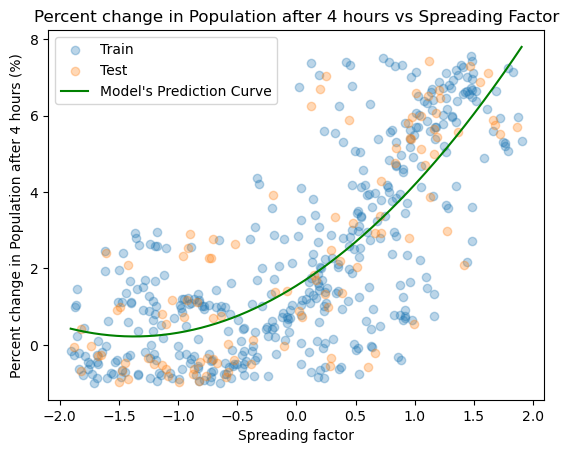

In [19]:
graph_model(X_train, y_train, X_test, y_test, model, poly)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4</b></div>

Now we will compute confidence intervals for the coefficients generated by our model specification. For the same degree polynomial regression fit above in 2.2, compute and plot the 95% confidence interval of the beta (i.e. $\beta$) values obtained in that regression model. Be certain to meet these primary requirements:
- Report the coefficient values of the model fit above in 2.2.
- Use bootstrapping to generate your 95% confidence intervals by refitting your model to each bootstrapped sample of your training data. You should use **100 bootstrapped samples**.
- For each bootstrap, store the coefficients of the model, and use those stored coefficients to compute the $2.5$ and $97.5$ confidence bounds.
- Plot the bootstrapped coefficients as a grid of histograms, one histogram for each $\beta_i$, illustrating the distribution of bootstrapped coefficients for each $\beta_i$. Each distribution should indicate the regions of 95% confidence. Use `plt.subplots(...)` to arrange your histograms as a grid of plots.
- Comment on your findings.

**Note:** Our use of the term "coefficients" includes the intercept. So the intercept should also get a confidence interval plot.

**Hints:** Wrapping your plotting code in a function may make the solution to the next question more concise.

In [20]:
# report hte coefficient values of the model fit above in 2.2
coefficients24 = np.insert(model.coef_, 0, model.intercept_)
print("my coefs (in order)", coefficients24)

my coefs (in order) [1.54791898 1.93796806 0.70637891]


In [21]:
# use bootstrapping to generate 95% confidence intervals for the coefficients
coefs = []
x_poly_train = pd.DataFrame(x_poly_train, columns=x_labels)
for i in range(100):
    shuffle = np.random.choice(x_poly_train.index, replace = True, size = len(x_poly_train.index)) 
    X_train_boot = x_poly_train.iloc[shuffle]
    y_train_boot = y_train.iloc[shuffle]
    model.fit(X_train_boot,y_train_boot)
    coefs.append(np.insert(model.coef_, 0, model.intercept_))

In [22]:
coefs = np.array(coefs)
boot_beta_df = pd.DataFrame({
    'feature': ['intercept'] + list(x_labels),
    'lower_bound': np.percentile(coefs, 2.5, axis=0),
    'upper_bound': np.percentile(coefs, 97.5, axis=0),
    'mean': np.mean(coefs, axis=0)
})
reshaped_coefs = coefs.T


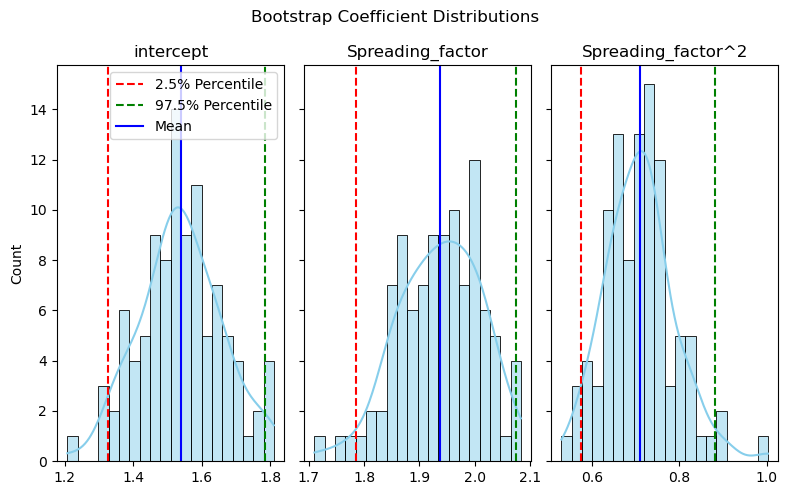

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(8, 5), sharey=True)
axs = axs.ravel()
for i in range(reshaped_coefs.shape[0]):
    sns.histplot(reshaped_coefs[i], bins = 20, ax=axs[i], kde=True, color='skyblue', edgecolor='black')
    axs[i].set_title(boot_beta_df.iloc[i]['feature'])
    axs[i].axvline(boot_beta_df.iloc[i]['lower_bound'], color='red', linestyle='--', label='2.5% Percentile')
    axs[i].axvline(boot_beta_df.iloc[i]['upper_bound'], color='green', linestyle='--', label='97.5% Percentile')
    axs[i].axvline(boot_beta_df.iloc[i]['mean'], color='blue', linestyle='-', label='Mean')

axs[0].legend()
plt.suptitle("Bootstrap Coefficient Distributions")
plt.tight_layout()
plt.show()

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

We see 3 coefficients which makes perfect sense for a guestimate of 2! 1 for the intercept, 1 for the spreading factor, and 1 for the spreading factor squared. The fact that none of the distributions of these intercepts includes 0, tells us that all 3 are important and the ideal degree of our model is therefore 2 or more! I am interested in the fact that spreading factor squared seems left skewed. I think this is because of chance (just how the sampling happened created an intercept). The mean for all 3 seems to sit squarely in the middle of the 2.5th precetnile and the 97.5th percentile, telling us the distributions are generally normal besides these outliers. They are also all pretty small intervals (~.2 to ~.4) telling us they are pretty sure where the coefficients lie

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.5</b></div>

Linear regression can be viewed probabilistically, with deviations from the regression line attributed to an error term, $ \epsilon $, distributed as:

$$ \epsilon \sim N(0, \sigma^2) $$

In this question, you'll estimate confidence intervals for the regression coefficients based on this probabilistic perspective. Follow these steps:

1. Compute $ \hat{\sigma}_\epsilon^2 $, an estimate for the variance of the error term.
2. Utilizing this estimated variance, derive the standard errors for your regression coefficients.
3. Construct 95% confidence intervals for the coefficients using their standard errors. For the z-value, use 1.96.
4. Visualize the 95% confidence intervals alongside those from the bootstrap method. The values of the interval bounds should be made explicit in the plot.

**Hints:**
- Ensure your design matrix, $ X $, includes an intercept column to compute a confidence interval for $ \beta_0 $.
- Bootstrap samples play no role in this calculation.

In [24]:
# Compute epsilon^2, an estimate for the variance of the error term.
n = x_poly_train.shape[0]
p = x_poly_train.shape[1]
variance =np.sum((y_train -  model.predict(x_poly_train)) ** 2) / (n - p)
variance

np.float64(2.6799991137390484)

In [25]:
# Utilizing this estimated variance, derive the standard errors for your regression coefficients.
# based on ed 655
x_poly_train_with_intercept = np.insert(x_poly_train, 0, 1, axis=1)
standard_errors = np.sqrt(np.diag(np.linalg.inv(x_poly_train_with_intercept.T @ x_poly_train_with_intercept) * variance))
standard_errors

array([0.11553745, 0.08115559, 0.08495484])

In [26]:
# 3. Construct 95% confidence intervals for the coefficients using their standard errors. For the z-value, use 1.96.
z = 1.96
lower_bound = coefficients24 - z * standard_errors
upper_bound = coefficients24 + z * standard_errors

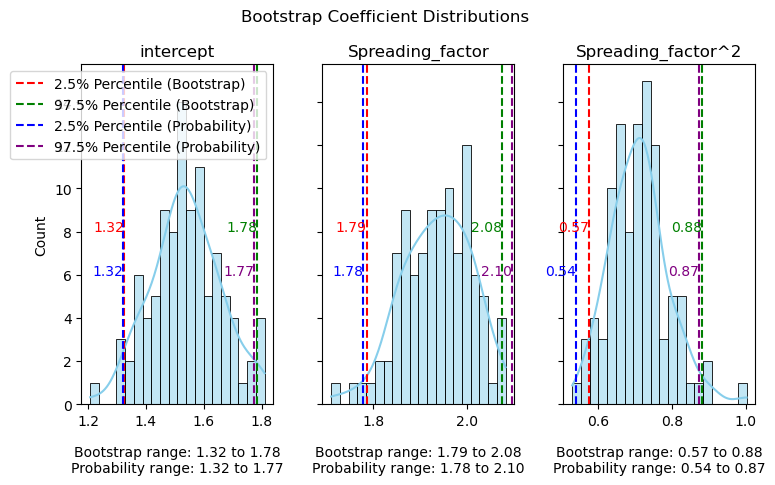

In [27]:
# 4. Visualize the 95% confidence intervals alongside those from the bootstrap method. The values of the interval bounds should be made explicit in the plot.
fig, axs = plt.subplots(1, 3, figsize=(8, 5), sharey=True)

axs = axs.ravel()
for i in range(reshaped_coefs.shape[0]):
    sns.histplot(reshaped_coefs[i], bins = 20, ax=axs[i], kde=True, color='skyblue', edgecolor='black')
    axs[i].set_title(boot_beta_df.iloc[i]['feature'])
    axs[i].axvline(boot_beta_df.iloc[i]['lower_bound'], color='red', linestyle='--', label='2.5% Percentile (Bootstrap)')
    axs[i].axvline(boot_beta_df.iloc[i]['upper_bound'], color='green', linestyle='--', label='97.5% Percentile (Bootstrap)')
    axs[i].axvline(lower_bound[i], color='blue', linestyle='--', label='2.5% Percentile (Probability)')
    axs[i].axvline(upper_bound[i], color='purple', linestyle='--', label='97.5% Percentile (Probability)')

    axs[i].text(boot_beta_df.iloc[i]['lower_bound'],8, f"{boot_beta_df.iloc[i]['lower_bound']:.2f}", color='red', ha='right')
    axs[i].text(boot_beta_df.iloc[i]['upper_bound'],8, f"{boot_beta_df.iloc[i]['upper_bound']:.2f}", color='green', ha='right')
    axs[i].text(lower_bound[i],6, f"{lower_bound[i]:.2f}", color='blue', ha='right')
    axs[i].text(upper_bound[i], 6, f"{upper_bound[i]:.2f}", color='purple', ha='right')

    note_text = (f"Bootstrap range: {boot_beta_df.iloc[i]['lower_bound']:.2f} to {boot_beta_df.iloc[i]['upper_bound']:.2f}\n"
                 f"Probability range: {lower_bound[i]:.2f} to {upper_bound[i]:.2f}")
    axs[i].annotate(note_text, xy=(0.5, -0.2), xycoords='axes fraction', ha='center', fontsize=10, color='black')

axs[0].legend()
plt.suptitle("Bootstrap Coefficient Distributions")
plt.tight_layout()
plt.show()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.6</b></div>

Reflect on the differences between the two sets of confidence intervals. Demonstrate at least one diagnostic making use of the model and/or training data to explore the potential reasons for any observed discrepancies in the confidence intervals. Be sure to explain the relevance of your diagnostic(s) to this particular task and interpret the results.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

For the 2.5th percetile estimates we see for all 3 coeficients that the bootstrapped method predicts a higher minimum than the probablistic method, therefore creating a tighter, more confident, range. For the 97th percentile we see that the bootstrapped method is larger than the proabbilistic method for the intercept and smaller for the other two coeficicents, but overall they are similar. This tells us about the distribution of the data as we assumed that it was noramlly distributed when we made our probabilistic model. Thus, since we see that both of these coeficients are left skewed, we see a higher probability percentile as it expects symmetry over the mean (not that more of the data would be left of the mean which would pull it lower). This diagnostic is visible in the histogram above. 

Another diagnostic is to plot residuals (see below). We see that as the spreading factor increases, the residuals increase (around 0) then decrease (around 1). Since it is not random and centered around 0, the data residuals aren't independent, telling us that our choice to assume they were normal (and predict probabilistically) shows an inaccurate view of the data. Presumably, homoskedasciity doesn't hold. 

Therefore, the probabilistic approach is less confident as the data doesn't seem normal and so we need to bootstrap (not assume a distribution)

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

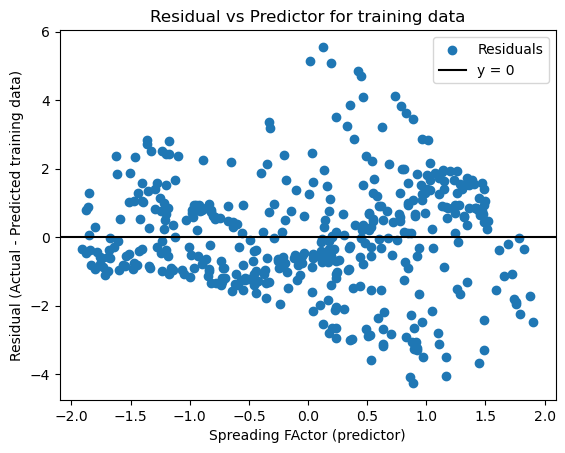

In [28]:
resids_train = y_train - model.predict(x_poly_train)
plt.scatter(X_train, resids_train)
plt.axhline(0, c='k')
plt.title('Residual vs Predictor for training data')
plt.xlabel('Spreading FActor (predictor)')
plt.ylabel('Residual (Actual - Predicted training data)')
plt.legend(labels=['Residuals', 'y = 0'])

<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Question 3: Single validation set [12 pts]</div> 

In this section you'll find the best degree polynomial relationship using a single validation set.

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1</b></div>

Split your original training data such that you separate out 20% into a single validation split. Use `random_state=1` and save the resulting splits as `x_train80`, `x_val`, `y_train80`, `y_val`. (This will prevent the overwriting of the original train data variables).

In [29]:
x_train80, x_val, y_train80, y_val = train_test_split(X_train, y_train, test_size=0.20, random_state=1)

In [30]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2</b></div>

- Fit polynomial regression models for **degrees 1 to 30 (inclusive)** on the 80% training set (one model for each degree polynomial regression).
- Store the train and validation MSE values for each model in lists called `train_mses` and `val_mses`.

In [31]:
train_mses = []
val_mses = []
degree_values = range(1, 31) 
lr = LinearRegression()
for d in degree_values:
    x80_poly_train, x20_poly_val, x20_labels, poly20 = convert_to_poly(x_train80, x_val, d)
    lr.fit(x80_poly_train, y_train80)
    train_mses.append(mean_squared_error(y_train80, lr.predict(x80_poly_train)))
    val_mses.append(mean_squared_error(y_val, lr.predict(x20_poly_val)))

In [32]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3</b></div>

- Generate a single plot illustrating the train and validation $MSE$ values for each fitted degree polynomial regression model.
- Identify and report the degree for which the validation error is lowest.

**Note:** Plotting the MSE on a log scale may be helpful.

In [33]:
def plot_mses(degree_values, train_mses, val_mses, val_mses_std, log):
    fig, ax = plt.subplots(figsize=(10, 6))
    ax.plot(degree_values, train_mses, label='Train MSE')
    if val_mses_std != 0:
        ax.errorbar(degree_values, val_mses, yerr=val_mses_std, label='Validation MSE', capsize=5)
    else:
        ax.plot(degree_values, val_mses, label='Validation MSE')
    ax.set_xlabel('polynomial degree')
    ax.set_ylabel('Mean Squared Error')
    ax.set_title('MSE vs Polynomial Degree')
    if log == True:
        ax.set_yscale('log')
    ax.grid(True)
    best_deg = degree_values[np.argmin(val_mses)]
    ax.axvline(best_deg, color='r', linestyle='--', label=f'Best degree = {best_deg}')
    ax.legend()
    return best_deg


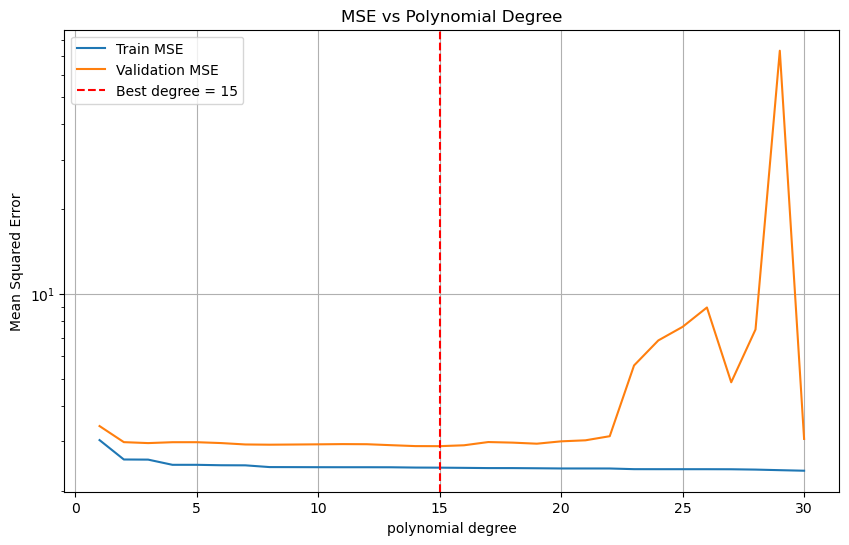

In [34]:
best_degree_single = plot_mses(degree_values, train_mses, val_mses, 0, True)


In [35]:
print("the degree with the lowest validation error is", best_degree_single)

the degree with the lowest validation error is 15


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.4</b></div>

Now, with the best degree selected, train the polynomial regression on the **complete training set** (including the observations that you had previously removed to make the validation set). 

Append a new dictionary to your `results` list for this model.

In [36]:
x_15_train, x_15_test, x15_labels, poly15 = convert_to_poly(X_train, X_test, best_degree_single)
model15 = LinearRegression().fit(x_15_train, y_train)

In [37]:
add_to_results(model15, x_15_train, x_15_test, y_train, y_test, "3.4")

In [38]:
# Display your results thus far.
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863
1,3.4,2.490946,2.736483


In [39]:
grader.check("q3.4")

q3.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.5</b></div>

Generate a plot of the data and your regression curve (similar to [Question 2.3](#part2)). Comment on how your model fits the data and compare it to the fit of your "guesstimated" model from [Question 2](#part2solutions).

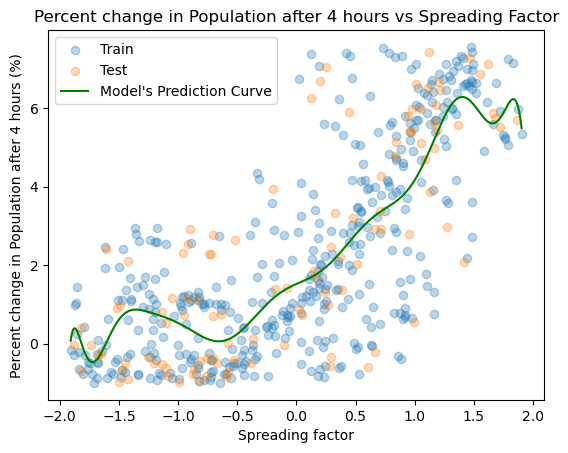

In [40]:
graph_model(X_train, y_train, X_test, y_test, model15, poly15)

This seems completly overfit! Whereas my guestimate generally understood the shape of the model but wasn't able to fully capture the spead by which it increased, this model adds many extra curves and ripples, seemingly trying to capture the shape of all data including the outliers. This is therefore overfit! We see, for example, if we had any data for a spreading factor of around -2.1, we would expect a percent change of approximately <0 as that matches all nearby data. Instead, we see that our model wuld predict a -.5% change (similarly for >2(! Thus, I would argue that my guestimate fit is a lot better than this one!

We also see that the validation error (that we want to minimize) here is 2.74 instead of 2.67. It seems surprising that it is higher given that we chose our degree in order to minimize it! This is because of the arbitrary training/validation split we chose (see below). Since that training set is biased, our model will be as well, thus the MSE for validation would be higher than with a different split. It would be better, then, to try and compare multiple splits! (See the vvalidation set below)

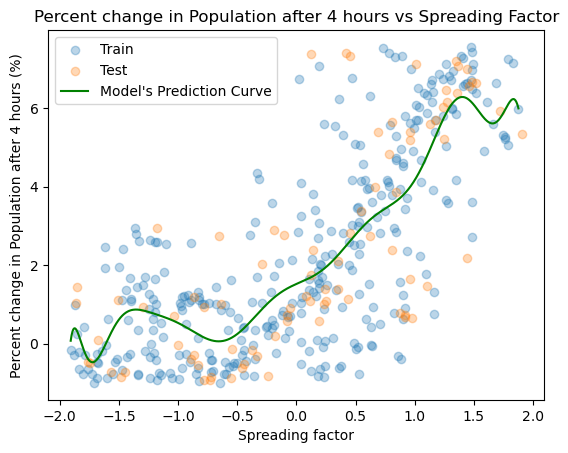

In [41]:
graph_model(x_train80, y_train80, x_val, y_val, model15, poly15)

<a id="part4"></a>

## <div class='exercise'>Question 4: Finding the best model by k-fold cross validation [14 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1</b></div>

In this part we find the best degree polynomial regression by running the model on a range of degree values and using k-fold cross validation. Note that `cross_validation` should be passed *all* training examples (*not* the 80% split from the previous question).

- Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ for each polynomial regression from **degree 1 to 30 (inclusive)**.
- For each degree:
    - store the mean train MSE across all $k$ folds in the list `train_mses_mean`
    - store the mean validation MSE across all $k$ folds in the list `val_mses_mean`
    - store the standard deviation  of the validation MSE across all $k$ folds in the list `val_mses_std`
    

In [42]:
k = 10
train_mses_mean = []
val_mses_mean = []
val_mses_std = []
for d in degree_values:
    x_d_train, x_d_test, x_d_labels, poly_d = convert_to_poly(X_train, X_test, d)
    cv_results = cross_validate(lr, x_d_train, y_train, cv=k, 
                                scoring='neg_mean_squared_error',
                                return_train_score=True)
    train_mses_mean.append(-cv_results['train_score'].mean())
    val_mses_mean.append(-cv_results['test_score'].mean())
    val_mses_std.append(cv_results['test_score'].std())

In [43]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2</b></div>

- Generate a single plot showing the mean train and validation $MSE$ values (see note below) for each degree polynomial regression, including the +/- 1 standard deviation bounds for the validation $MSE$ values.
- Comment on trends and findings illustrated by your plot.
- Print the degree of the best model, identified based on the lowest mean validation $MSE$, along with the corresponding mean train and validation $MSE$ values.

**NOTE:** When we refer to train and validation $MSE$ values here in Question 4.2 and in future problems where we are performing cross validation, we are referring specifically to the cross-validation generated train and validation $MSE$ values. Just please remember, when accessing your validation $MSE$ values while performing cross validation with scikit-learn's `cross_validate(...)`, scikit-learn rather confusingly refers to its validation scores as `test_score` in the dictionary that it returns, even though those values are actually validation scores. Please see the `cross_validate(...)` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) for more info on this function.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The MSE on the training data gets smaller and smaller (better and better) as we are simply fitting to that data more and more. This is an example of overfitting. The validation data MSE decreases (reaching a minimum at 8), then stays small, then increases and jumps around. It increases due to the aformentioned overfitting. If the model is too fit to training data, the validation MSE will be bad/large. The decrease at d=28 may be due to the fact that randomly, the validation data was split to fit very well for this model, but doesn't mean that the model is actully good. Also, this decrease is still a larger error than d=8 so its not imporant in choosing our ideal degree. We would expect in general that our ideal degree would be close to degrees with similarly low MSEs, not high ones, as it doesn't make sense for data to oscillate between overfit and underfit as degree increases. This is further confirmed by the larger standard deviations, showing irreliability.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

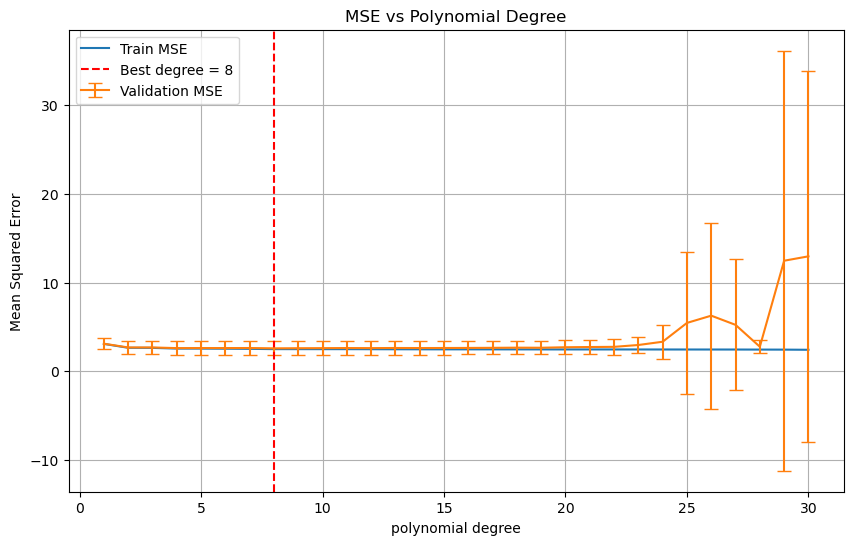

In [44]:
best_degree_cross = plot_mses(degree_values, train_mses_mean, val_mses_mean, val_mses_std, False)


In [45]:
print("our best degree is", best_degree_cross)
print("it has a mean train mse of ", train_mses_mean[np.argmin(val_mses_mean)])
print("it has a mean val mse of ", val_mses_mean[np.argmin(val_mses_mean)])
print("it has a val std of ", val_mses_std[np.argmin(val_mses_mean)])

our best degree is 8
it has a mean train mse of  2.5081491803463067
it has a mean val mse of  2.5990753511998657
it has a val std of  0.7791359728631119


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3</b></div>

Fit the best model based on the entire training data and report the $MSE$.


- For the best degree polynomial regression identified in Question 4.2 above, train on the complete training data and predict on the test data.
- Append a new dictionary for this model to the `results` list. 

In [46]:
x_8_train, x_8_test, x_8_labels, poly8 = convert_to_poly(X_train, X_test, best_degree_cross)
model8 = LinearRegression().fit(x_8_train, y_train)

In [47]:
add_to_results(model8, x_8_train, x_8_test, y_train, y_test, "4.3")

In [48]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.4</b></div>

- Generate a plot of the data and your regression curve (similar to [Question 2.3](#part2)).
- Display the coefficients of your model.
- Display `results` as a DataFrame (there should now be 3 entries).
- Comment on how your model fits the data and how your model compares relative to the prior best-fit model you generated using just a single validation set in [Question 3](#part3solutions).

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

We see our model fits the data much better than the single validation set. First, visually, it is less wiggly and doesn't have the sharp decreases/increases at the boundaries [-2,2] as it did before. Thus, there is an understanding that it is more generalizable. Second, the test MSE is lower than both previous models, implying it fits the data better. We also see a better test MSE than our guestimate model as well, telling us we are getting closer to the ideal degree. That said, the model is not perfect. We see the samme issue as before where if we had a spread of -2.1, we would expect a 0% change but the mdodel predicts 1%. Thus, we need to reduce the degree to reduce overfitting.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

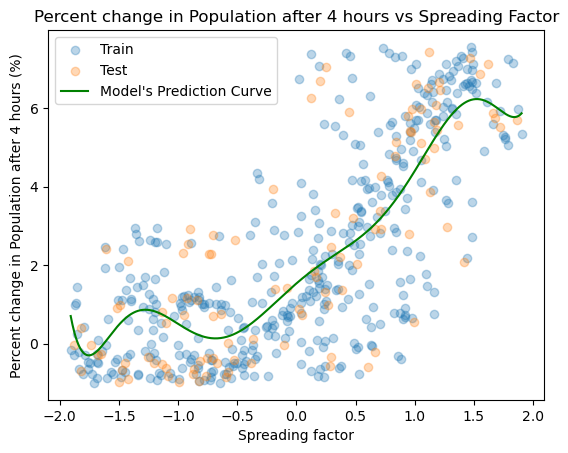

In [49]:
# generate plot
graph_model(X_train, y_train, X_test, y_test, model8, poly8)

In [50]:
# display coefficients
coefficients = np.insert(model8.coef_, 0, model8.intercept_)
coefficients

array([ 1.53533357,  2.59702778, -1.09486847, -1.18913441,  3.48314914,
        0.65287664, -1.71300787, -0.11530516,  0.24041837])

In [51]:
# display results
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863
1,3.4,2.490946,2.736483
2,4.3,2.512517,2.613011


<!-- END QUESTION -->

<a id="part5"></a>

## <div class='exercise'>Question 5: Finding the most consistent model using k-fold cross validation with bootstraps [16 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.1</b></div>

In the previous part, we used $k$-fold cross validation to find the best model. But how confident are you of your estimated best degree? We have already used bootstraps in [Question 2.4](#part2) to estimate the confidence intervals of our $\beta_i$ values. In this segment, we will use bootstrapping to test the robustness of our estimation.

- Similar to Question 2.4, **use 100 bootstraps** of your data.
- For each bootstrap:
  - Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ *for each polynomial regression* of **degrees 1 to 30 (inclusive)**.
  - Select the best degree polynomial based on the lowest mean cross-validation MSE and store this degree in a list called `best_degrees`.
- After completing your bootstraps, `best_degrees` should have 100 elements, one degree for each completed bootstrap.

**NOTE:** Once complete, your code for this problem will likely take several minutes to execute. This is to be expected.

In [52]:
best_degrees = []
for i in range(100):
    shuffle = np.random.choice(X_train.index, replace = True, size = len(X_train.index)) 
    X_train_boot = X_train.iloc[shuffle]
    y_train_boot = y_train.iloc[shuffle]
    curr_best_mean = np.inf
    best_deg = 0
    for d in degree_values:
        X_train_boot_poly, X_test_poly, x_boot_labels, poly_boot = convert_to_poly(X_train_boot, X_test, d)
        cv_results = cross_validate(lr, X_train_boot_poly, y_train_boot, cv=10, 
                                scoring='neg_mean_squared_error',
                                return_train_score=True)
        if -cv_results['test_score'].mean() < curr_best_mean:
            curr_best_mean = -cv_results['test_score'].mean()
            best_deg = d
    best_degrees.append(best_deg)

In [53]:
grader.check("q5.1")

q5.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.2</b></div>

Generate a well-labeled bar plot, with the polynomial degree on the $x$-axis and the number of times that degree was deemed best on the $y$-axis, using the `best_degrees` saved during your bootstraps.

**Hint:** You may want to make use of `Counter` which has been imported for your from the `collections` module of the standard Python library.

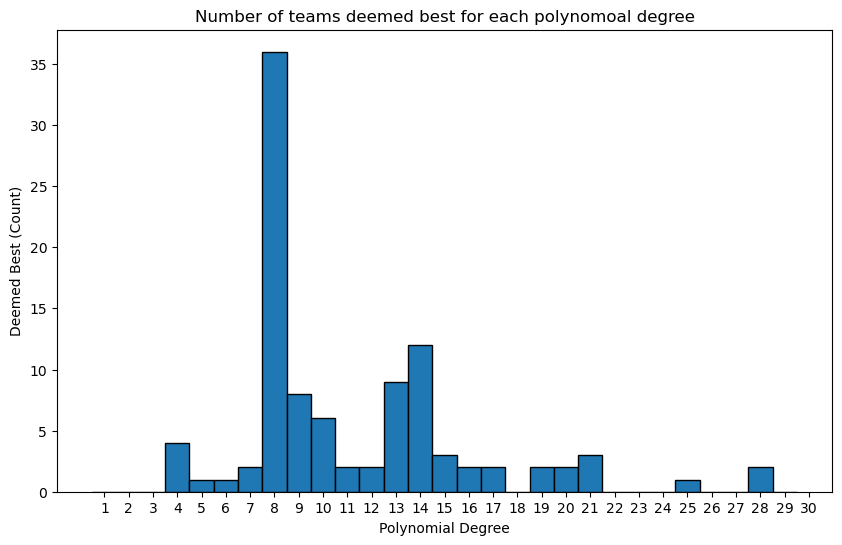

In [54]:
plt.figure(figsize=(10, 6))
plt.hist(best_degrees, bins=degree_values, edgecolor='black', align='left')
plt.xticks(degree_values)
plt.xlabel('Polynomial Degree')
plt.ylabel('Deemed Best (Count)')
plt.title('Number of teams deemed best for each polynomoal degree')
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.3</b></div>

What are your observations from the plot above? 

- Why do you see so much variation in the "best degree" over the bootstraps?
- Which degree polynomial regression will you choose as your overall best degree based on your bootstrapped results, and why? 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

1. We see so much variation in the "best degree" because each boostrap is a random sample, generating a new dataset. Since we have so many bootstraps, it makes sense that the data may form different shapes and therefore need different models to encapsualte them. 
2. Based on the above histogram, we see that a degree of 8 creates the minumum validation MSE the most of the time (with 4 following close behind). Thus, we can assume that it will work best on all the data that we don't have and can't test on. Therefore, it is the most generalizable and should be chosen

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.4</b></div>

Now, with the overall best degree identified with your bootstrapping results above, train the polynomial regression model on the **complete training set**. Append a new dictionary for this model to your `results` list. 

In [55]:
x_8_train, x_8_test, x_8_labels, poly8 = convert_to_poly(X_train, X_test, best_degree_cross)
model8 = LinearRegression().fit(x_8_train, y_train)
add_to_results(model8, x_8_train, x_8_test, y_train, y_test, "5.4")

In [56]:
grader.check("q5.4")

q5.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.5</b></div>

- Generate a plot of the data and your regression curve.
- Display `results` as a DataFrame.
- Comment on how your model fits the data and compare it to the fit of your cross-validated model from [Question 4](#part4solutions).

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Here we see that again, a model with degree 8 is consiered the best model! As it is the exact same model, it fits identiacally to question 4 (both in overall look and in MSE). That said, now that we have bootstrapped it, we know it is more generalizable to other datasets. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

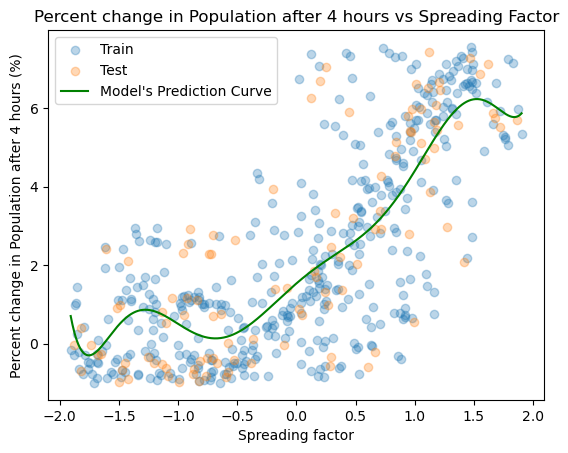

In [57]:
graph_model(X_train, y_train, X_test, y_test, model8, poly8)

In [58]:
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863
1,3.4,2.490946,2.736483
2,4.3,2.512517,2.613011
3,5.4,2.512517,2.613011


<!-- END QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: Improving model consistency with LASSO regularization [26 pts]</div> 

[Return to contents](#contents)

In the previous sections, we compared many polynomial models to find the best degree. For each model of degree $n$, we considered all polynomial coefficients *up to and including* **degree $n$** using `PolynomialFeatures(...)`. In this section we will consider polynomial features of $n=30$, and a **best model** that could be chosen from any possible combination of our 30 degrees.

For instance, we could choose a best model with an arbitrary set of polynomial degrees up degree 30, such as $x^i \in [x^1, x^5, x^{19}, x^{24}]$, rather than the standard approach of using *all* consecutive degrees up to our maximum degree $n=30$ as in $x^i \in [x^1, ... , x^{30}]$.

However, the total number of such possible models for $n=30$ is $2^{30}\approx10^9$, and searching through all of them would be laborious and computationally inefficient. Instead, we can use $LASSO$ (i.e. $L1$) regularization, which "switches off" highly unstable degree coefficients by shrinking them to zero (or very close to zero), thus giving us an efficient solution to this particular combinatorial challenge.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.1</b></div>

**Find the best hyper-parameter alpha, $\alpha$**

Use the `LassoCV` estimator to find the best regularization parameter from $\alpha \in [10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}]$
- Store the mean cross-validation MSEs across each fold in `lassoCV_val_mses_mean`
- Save the best $\alpha$ based on the mean cross-validation MSE in `best_alpha`

You should read the documentation for [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). Some important information about this estimator:
- After calling `fit`, the model is now the one fit on the entire training data using the best alpha based on the mean CV MSE.
- the `mse_path_` attribute contains the validation scores on each fold for each candidate alpha.
- the `alpha_` attribute contains the best regularization parameter found through cross-validation

**Tips:** You should try adjusting `LassoCV`'s `max_iter` argument to prevent convergence warnings. If you are unable to prevent them with a large number of iterations (~100,000) then you can silence them with:
```{python}
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
```
Do not worry about normalizing your $x$ values for any parts of Question 6. It will not meaningfully affect our final results here.

In [59]:
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)

In [60]:
lasso_alphas = np.logspace(-5, -1, 5)
lassoCV_val_mses_mean = []
best_alpha = 0
x_30_train, x_30_test, x_30_labels, poly30 = convert_to_poly(X_train, X_test, 30)
lasso = LassoCV(alphas=lasso_alphas, cv=10).fit(x_30_train, y_train)
best_alpha = lasso.alpha_
lassoCV_val_mses_mean = lasso.mse_path_.mean(axis=1)

In [61]:
grader.check("q6.1")

q6.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.2</b></div>

Generate two plots:
- One showing the mean validation $MSE$ values for each regularization parameter $\alpha$, identifying the best $\alpha$.
- Another showing the values of each coefficient in the LASSO model using the best $\alpha$. 

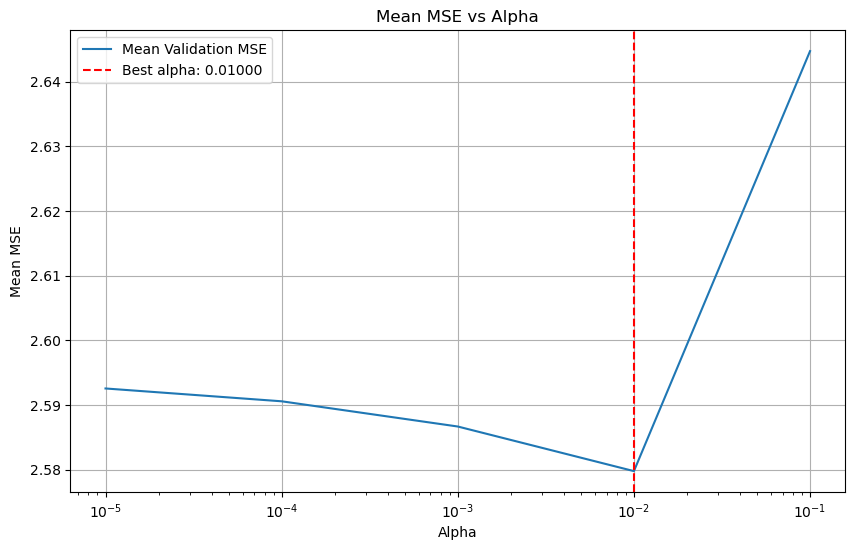

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(lasso_alphas, lassoCV_val_mses_mean[::-1], label='Mean Validation MSE')
plt.axvline(best_alpha, color='red', linestyle='--', label=f'Best alpha: {best_alpha:.5f}')
plt.xscale('log')
plt.xlabel('Alpha')
plt.ylabel('Mean MSE')
plt.title('Mean MSE vs Alpha')
plt.legend()
plt.grid(True)

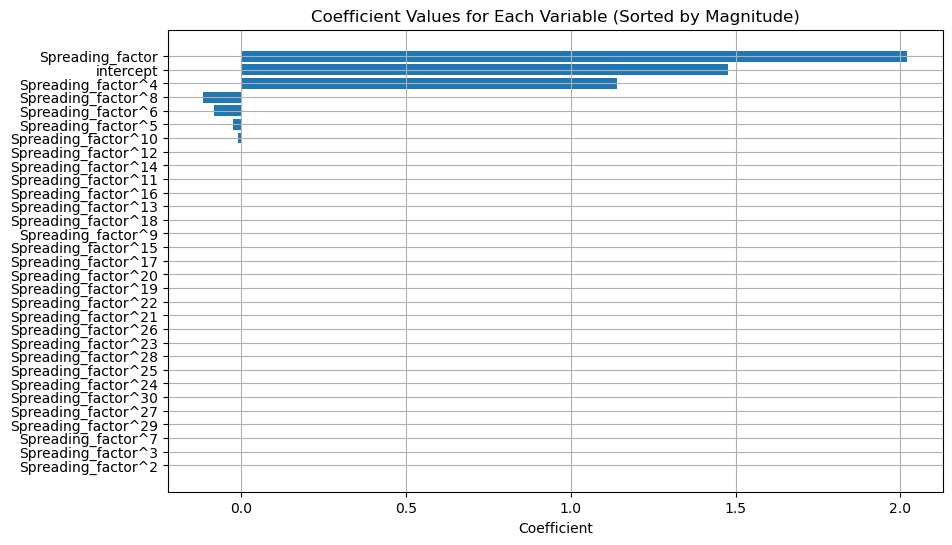

In [63]:
coefficients = np.insert(lasso.coef_, 0, lasso.intercept_)
sorted_indices = np.argsort(np.abs(coefficients))[::1]
sorted_coefficients = coefficients[sorted_indices]
sorted_labels = np.array( np.insert(x_30_labels, 0, "intercept"))[sorted_indices]

plt.figure(figsize=(10, 6))
plt.barh(range(len(sorted_coefficients)), sorted_coefficients)
plt.yticks(range(len(sorted_coefficients)), sorted_labels)
plt.xlabel('Coefficient')
plt.title('Coefficient Values for Each Variable (Sorted by Magnitude)')
plt.grid(True)
plt.show()

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.3</b></div>

**Find the most significant degrees**

**NOTE: The code for this question has been provided. It can take several minutes to run. Just be sure to answer the interpretation part of the question.**

From the previous section, you will now have the `best_alpha` hyperparameter. Now, we will use this best $\alpha$ value to find the "most significant" set of polynomial degrees by using bootstraps.

What we mean by this is, for each bootstrap of the data, you will get some set of degrees that are **significant**, as will be indicated by the value of their coefficients. Typically, while using $LASSO$ regularization, we would consider $\mid\beta_i\mid \gt 0$ as an indication of a particular coefficient's significance. However, for this particular exercise, we are going to use $\mid\beta_i\mid \gt 0.1$ as our criteria for significance (we have found this $0.1$ threshold to work well when designing this particular problem).

Based on this criteria, you will identify which degree coefficients are significant over many bootstrapped iterations with $n=30$ polynomial features and your chosen best $\alpha$ from Question 6.1.

- Use polynomial features with **degree 30**.
- Use a dictionary called `significant_degrees` to store a cumulative count for each degree identified as significant during your bootstraps.
- Run at least 100 bootstraps of your data.
- For each bootstrap:
  - Train a `Lasso(...)` model with the `best_alpha` identified in Question 6.1.
  - Identify the significant polynomial degree coefficients using $\mid\beta_i\mid \gt 0.1 $ as our threshold for significance.
  - For each significant coefficient, update the count of that degree in your `significant_degrees` dictionary.
- Generate a bar plot showing the count for each degree, showing how many times it was identified as significant over your bootstraps.
- Based on this plot, there should likely be a clear maximum degree, above which, few if any iterations have been identified as significant. Interpret your bar plot, choose a maximum degree polynomial based upon it, and explain your rationale for choosing that degree.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

We see bars for degrees 0-8 and none for degrees 9-30. This tells us that during boostrapping degrees 0-8 routinely show up with high coefficients and are therefore importnant whereas 9-30 never do. This matches our previous undesrtanding of the fact that a degree 8 polynomial will be our best predictor. That said, some degrees show up more than others. Speciifically, 0,1,4,6,and 8 have really large bars, 5 has a medium bar, and 2,3,7 of small bars. This tells us that overall 0,1,4,6,and 8 are more important than 2,3,7. Thus there are two possible arguements. 1. That we should use an 8 degree polynomial (coefficients 0-8) or 2, a 8 degree polynomial but only include coefficinets for the 5 significant predictors (0,1,4,6,8). For the sake of this question, I will chose an **8 degree** polynomial as we are asked to simply to choose a maximum degree

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
/var/folders/y8/22y1cb995pg8pbgkn831zt8m0000gn/T/ipykernel_10889/1614806114.py:55: SyntaxWarning: invalid escape sequence '\m'
  f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "


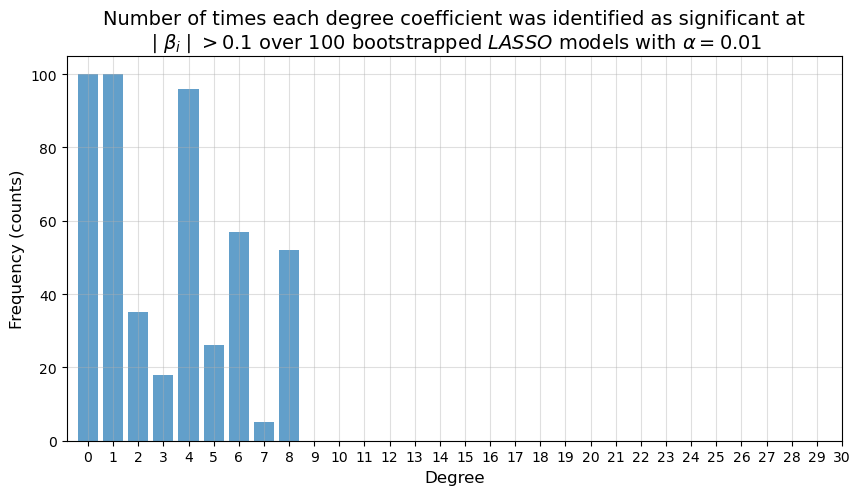

In [64]:
# your code here
# Set bootstrapping parameters
numboot = 100
max_degree = 30

significant_degrees = {}

# Perform bootstraps
df_train = pd.read_csv('data/bacteria_train.csv')

include_bias = False # No column of ones from PolynomialFeatures
fit_intercept = True # We will get it from LinearRegression.fit()

for i in range(numboot):
    df_boot = df_train.sample(frac=1, replace=True)
    x_train_boot = df_boot[["Spreading_factor"]]
    x_poly_train_boot = PolynomialFeatures(
        max_degree, include_bias=include_bias
    ).fit_transform(x_train_boot)
    y_train_boot = df_boot.Perc_population

    lasso = Lasso(
        fit_intercept=fit_intercept,
        max_iter=5_000,
        alpha=best_alpha,
    )
    lasso.fit(x_poly_train_boot, y_train_boot)
    
    if fit_intercept==True:
        coefficients = [lasso.intercept_, *lasso.coef_]
    else:
        # If you got your constant from PolynomialFeatures and not LinearRegression,
        # then the intercept is actually the first coef in the model.
        # But this would be problematic when using regularization. Can you see why?
        coefficients = lasso.coef_

    for i in np.where(np.abs(coefficients)>0.1)[0]:
        if i not in significant_degrees.keys():
            significant_degrees[i]=1
        else:
            significant_degrees[i]+=1

fig, ax = plt.subplots(figsize=(10,5))

lists = sorted(significant_degrees.items())

x, y = zip(*lists)

ax.bar(x, y, alpha=0.7)
ax.set_xlabel("Degree", fontsize=12)
ax.set_ylabel("Frequency (counts)", fontsize=12)
ax.set_xticks(range(max_degree+1))
ax.set_title(
    "Number of times each degree coefficient was identified as significant at\n"
    f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "
    f"with $\\alpha={best_alpha}$",
    fontsize=14,
)
plt.grid(":", alpha=0.4)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.4</b></div>

From our Question 6.3 results, we can see that only some degrees are consistently significant over many bootstraps.

- Use polynomial features based on the maximum degree you identified using your results from Question 6.3 (for the sake of simplicity, use all degrees up to that maximum degree as is typically done in polynomial regression).
- Train your **LASSO** regularized model using your `best_alpha` hyper-parameter on the entire training set.
- Append a new dictionary for this model to your `results` list.

In [65]:
x_8_train, x_8_test, x_8_labels, poly8 = convert_to_poly(X_train, X_test, 8)
model = Lasso(alpha=best_alpha).fit(x_8_train, y_train)
add_to_results(model, x_8_train, x_8_test, y_train, y_test, "6.4")

In [66]:
grader.check("q6.4")

q6.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.5</b></div>

- Generate a plot of the data and your regression curve.
- Report the polynomial degrees and corresponding coefficients for this fully trained model that have an absolute value greater than 0.1 (i.e. $\mid\beta_i\mid \gt 0.1 $)
- Display `results` as a DataFrame.

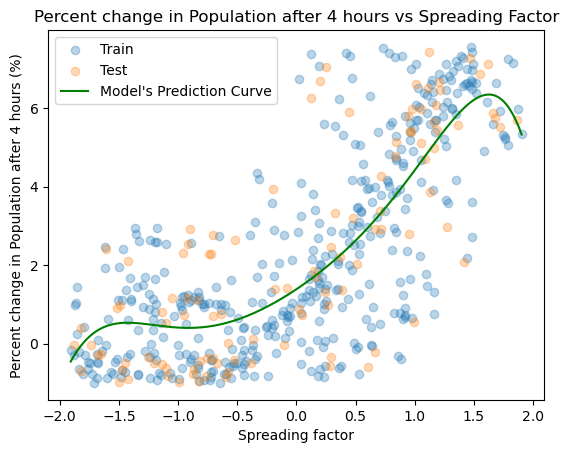

intercept: 1.39
Spreading_factor: 2.01
Spreading_factor^2: 0.87
Spreading_factor^4: 0.28
Spreading_factor^6: -0.13


,model,train_mse,test_mse
0,2.2,2.661715,2.674863
1,3.4,2.490946,2.736483
2,4.3,2.512517,2.613011
3,5.4,2.512517,2.613011
4,6.4,2.559336,2.594992


In [67]:
graph_model(X_train, y_train, X_test, y_test, model, poly8)
coefficients = np.insert(model.coef_, 0, model.intercept_)
labels = np.insert(x_8_labels, 0, "intercept")
for i in range(len(coefficients)):
    if abs(coefficients[i]) > 0.1:
        print(f"{labels[i]}: {coefficients[i]:.2f}")
pd.DataFrame(results)


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.6</b></div>

**What are your observations?**

- Compare your `best_degree` from [Question 5](#part5solutions) with your chosen degree in 6.4 above and comment on the difference.
- Compare your test $MSE$ in this question with the result from question 5. Which one is smaller, and by how much?
- Which degree coefficients in your best fit model from 6.4 are significant? If not all coefficients are significant, why?
- Would you expect your current model from 6.4 to be more "reliable" or robust than the models in Question 5 and prior? On what basis would you make a claim of its robustness?


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

We see that our chosen degree, 8, is the same as our `best_degree = 8` from question 5. That said, out graphs look different! Here, as we only really include 5 coefficients rathar than 9 (8 + the intercept) we have a less overfit model. All other coefficients go to 0 through lasso!

Thus, we have a lower test_mse than before, although our train mse is slightly higher, telling us while we are less perfectly fit to our training data, our model is generalizable! More specifically, the test_mse is smaller by .02 (about 1%).

We see only 0 (the intercept),1,2,4,6 end up being significant as printed above. This is because lasso regression penalizes large, unnnescessary coefficients that cancel each other out, sending them to 0. Thus, we are only left with the most importnatn ones. 

Yes! I would expect it to be more reliable. As previously mentioned, I feared that my previous models were overfit. They seemed overly curvy and didn't match the overall shape of my data. Thus, they weren't very generalizable. Now, our data looks much less overfit visually. It also has a lower test MSE telling us it works on our test data. Finally, due to the bootstrapping in 6.3, we can be sure that it could work for all similar datasets. In a way, we used every technique from previous parts, and combined it to make our ideal model, something simple (not too many coefs) with a low MSE that has been optimized by boostrapping and lasso (coefficients don't cancel out making a wobbly model).

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<a id="part7"></a>

## <div class='exercise'>Question 7: Analyze your best test MSEs for each sub section of the homework [6 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q7.1</b></div>

Using the `results` list, generate a bar plot illustrating the test $MSE$ values for each of the models. Display `results` as a Dataframe as well.

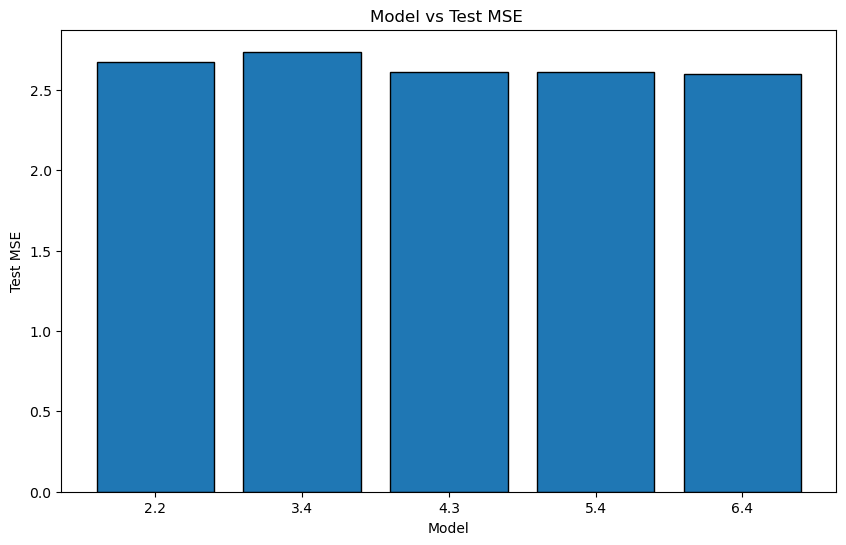

,model,train_mse,test_mse
0,2.2,2.661715,2.674863
1,3.4,2.490946,2.736483
2,4.3,2.512517,2.613011
3,5.4,2.512517,2.613011
4,6.4,2.559336,2.594992


In [68]:
df = pd.DataFrame(results)

plt.figure(figsize=(10, 6))
plt.bar(df['model'], df['test_mse'], edgecolor='black')
plt.xlabel('Model')
plt.ylabel('Test MSE')
plt.title('Model vs Test MSE ')
plt.show()

df


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q7.2</b></div>

Which model do you think is best, and why? What are some of that model's drawbacks compared to the other models? 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

I think the 8 degree lasso regression (6.4) was our best model! As previously discussed, it has the best test_mse and also generalizes to other datasets via boostrap. It seems to visually fit the data and doesn't have too many coefficients that cancel each other out. 

That said, some drawbacks include

1. Compute -- it took a while to boostrap all our data and choose our model. We might want to choose something else if we want to get a loose estimation from the data. 
2. Arbitrariness -- we picked the alpha options manually. Maybe it would have been better to have more options as the alpha really effects the importance of coefficient magnitudes
3. Recreatiability -- because of boostrapping, we fit the model to a new dataset every time. Thus, someone else may not get the exact same coefficients as us with the exact same method. It is hard, therefore, to compare models as randomness is involved. 
4. Not that different! We see that there is very similar MSE for models 4.3 (which was easy to do) and 6.4 (which was hard). If we want a generally good but not great model, we could pick 4.3!

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

I liked this homework although it felt repetitive at times. The hardest part was honestly just making sure a small mistake in one place didn't have cascading effects. I think next time I would differentiate my variable names instead of writing over my old variables. I also would work with a friend to check my models because something like degree = 8 feels objectively wrong so its confusing when my code reccomends it. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [69]:
hours_spent_on_hw = 8

In [70]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [71]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 0.97 minutes for this notebook to run


🌈 **This concludes HW3. Thank you!**

[Return to contents](#contents)